Training Q-Learning Agent on Grid World...
Episode 50: Avg Reward = 77.00, Avg Steps = 21.98
Episode 100: Avg Reward = 92.14, Avg Steps = 8.86
Episode 150: Avg Reward = 92.22, Avg Steps = 8.78
Episode 200: Avg Reward = 92.12, Avg Steps = 8.88
Episode 250: Avg Reward = 92.42, Avg Steps = 8.58
Episode 300: Avg Reward = 91.80, Avg Steps = 9.20
Episode 350: Avg Reward = 91.94, Avg Steps = 9.06
Episode 400: Avg Reward = 92.30, Avg Steps = 8.70
Episode 450: Avg Reward = 91.88, Avg Steps = 9.12
Episode 500: Avg Reward = 92.00, Avg Steps = 9.00


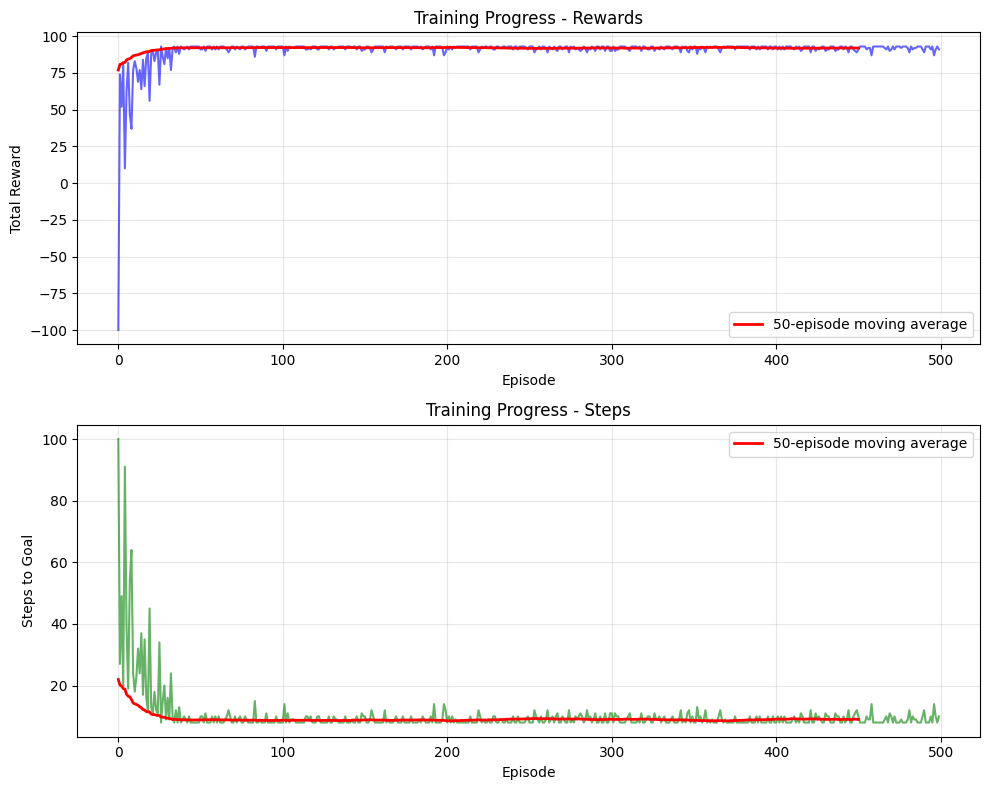


Learned Policy (arrows show best action):


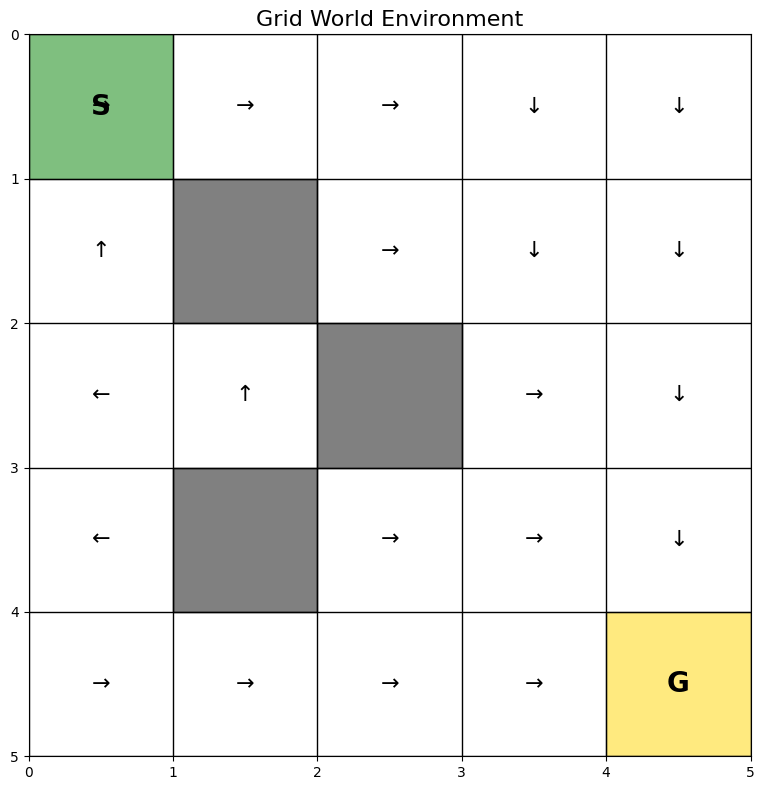


Testing trained agent:

Test Episode 1:
Start: (0, 0)
Goal reached! Steps: 8, Total Reward: 93
Path: (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (1, 3) -> (2, 3) -> (2, 4) -> (3, 4) -> (4, 4)

Test Episode 2:
Start: (0, 0)
Goal reached! Steps: 8, Total Reward: 93
Path: (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (1, 3) -> (2, 3) -> (2, 4) -> (3, 4) -> (4, 4)

Test Episode 3:
Start: (0, 0)
Goal reached! Steps: 8, Total Reward: 93
Path: (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (1, 3) -> (2, 3) -> (2, 4) -> (3, 4) -> (4, 4)

Test Episode 4:
Start: (0, 0)
Goal reached! Steps: 8, Total Reward: 93
Path: (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (1, 3) -> (2, 3) -> (2, 4) -> (3, 4) -> (4, 4)

Test Episode 5:
Start: (0, 0)
Goal reached! Steps: 8, Total Reward: 93
Path: (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (1, 3) -> (2, 3) -> (2, 4) -> (3, 4) -> (4, 4)

Training complete! The agent has learned to navigate from S to G.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

class GridWorld:
    """Simple grid world environment for reinforcement learning"""
    
    def __init__(self, size=5):
        self.size = size
        self.start = (0, 0)  # Top-left corner
        self.goal = (size-1, size-1)  # Bottom-right corner
        self.obstacles = [(1, 1), (2, 2), (3, 1)]  # Some obstacles
        self.reset()
    
    def reset(self):
        """Reset agent to start position"""
        self.agent_pos = self.start
        return self.agent_pos
    
    def step(self, action):
        """Execute action and return new state, reward, done"""
        # Actions: 0=up, 1=right, 2=down, 3=left
        moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        
        # Calculate new position
        new_pos = (
            self.agent_pos[0] + moves[action][0],
            self.agent_pos[1] + moves[action][1]
        )
        
        # Check boundaries
        if (0 <= new_pos[0] < self.size and 
            0 <= new_pos[1] < self.size and
            new_pos not in self.obstacles):
            self.agent_pos = new_pos
        
        # Calculate reward
        if self.agent_pos == self.goal:
            reward = 100  # Large reward for reaching goal
            done = True
        elif self.agent_pos in self.obstacles:
            reward = -10  # Should not happen with boundary check
            done = False
        else:
            reward = -1  # Small penalty for each step
            done = False
        
        return self.agent_pos, reward, done
    
    def render(self, q_table=None):
        """Visualize the grid world"""
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Draw grid
        for i in range(self.size + 1):
            ax.axhline(i, color='black', linewidth=1)
            ax.axvline(i, color='black', linewidth=1)
        
        # Draw obstacles
        for obs in self.obstacles:
            rect = Rectangle((obs[1], obs[0]), 1, 1, 
                           facecolor='gray', edgecolor='black')
            ax.add_patch(rect)
        
        # Draw start
        start_rect = Rectangle((self.start[1], self.start[0]), 1, 1,
                             facecolor='green', edgecolor='black', alpha=0.5)
        ax.add_patch(start_rect)
        ax.text(self.start[1]+0.5, self.start[0]+0.5, 'S', 
                ha='center', va='center', fontsize=20, fontweight='bold')
        
        # Draw goal
        goal_rect = Rectangle((self.goal[1], self.goal[0]), 1, 1,
                            facecolor='gold', edgecolor='black', alpha=0.5)
        ax.add_patch(goal_rect)
        ax.text(self.goal[1]+0.5, self.goal[0]+0.5, 'G', 
                ha='center', va='center', fontsize=20, fontweight='bold')
        
        # Draw Q-values as arrows if provided
        if q_table is not None:
            action_symbols = ['↑', '→', '↓', '←']
            for i in range(self.size):
                for j in range(self.size):
                    if (i, j) not in self.obstacles and (i, j) != self.goal:
                        best_action = np.argmax(q_table[i, j])
                        ax.text(j+0.5, i+0.5, action_symbols[best_action],
                               ha='center', va='center', fontsize=16)
        
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.set_title('Grid World Environment', fontsize=16)
        plt.tight_layout()
        return fig, ax


class QLearningAgent:
    """Q-Learning agent for reinforcement learning"""
    
    def __init__(self, n_states, n_actions, learning_rate=0.1, 
                 discount_factor=0.95, epsilon=0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        
        # Initialize Q-table with zeros
        self.q_table = np.zeros((n_states, n_states, n_actions))
    
    def choose_action(self, state, training=True):
        """Epsilon-greedy action selection"""
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            return np.argmax(self.q_table[state[0], state[1]])
    
    def update(self, state, action, reward, next_state, done):
        """Update Q-value using Q-learning formula"""
        current_q = self.q_table[state[0], state[1], action]
        
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.q_table[next_state[0], next_state[1]])
        
        # Q-learning update rule
        self.q_table[state[0], state[1], action] = (
            current_q + self.lr * (target - current_q)
        )


def train_agent(episodes=500):
    """Train the Q-learning agent"""
    # Create environment and agent
    env = GridWorld(size=5)
    agent = QLearningAgent(
        n_states=env.size, 
        n_actions=4,
        learning_rate=0.1,
        discount_factor=0.95,
        epsilon=0.1
    )
    
    # Training metrics
    episode_rewards = []
    episode_steps = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        max_steps = 100
        
        while steps < max_steps:
            # Choose action
            action = agent.choose_action(state)
            
            # Take action
            next_state, reward, done = env.step(action)
            
            # Update Q-table
            agent.update(state, action, reward, next_state, done)
            
            # Update metrics
            total_reward += reward
            steps += 1
            state = next_state
            
            if done:
                break
        
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        
        # Print progress
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            avg_steps = np.mean(episode_steps[-50:])
            print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}, "
                  f"Avg Steps = {avg_steps:.2f}")
    
    return env, agent, episode_rewards, episode_steps


def plot_training_progress(episode_rewards, episode_steps):
    """Plot training metrics"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot rewards
    ax1.plot(episode_rewards, alpha=0.6, color='blue')
    ax1.plot(np.convolve(episode_rewards, np.ones(50)/50, mode='valid'), 
             color='red', linewidth=2, label='50-episode moving average')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Training Progress - Rewards')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot steps
    ax2.plot(episode_steps, alpha=0.6, color='green')
    ax2.plot(np.convolve(episode_steps, np.ones(50)/50, mode='valid'), 
             color='red', linewidth=2, label='50-episode moving average')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps to Goal')
    ax2.set_title('Training Progress - Steps')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def test_agent(env, agent, n_episodes=5):
    """Test the trained agent"""
    print("\nTesting trained agent:")
    
    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        path = [state]
        
        print(f"\nTest Episode {episode + 1}:")
        print(f"Start: {state}")
        
        while steps < 50:
            action = agent.choose_action(state, training=False)
            next_state, reward, done = env.step(action)
            total_reward += reward
            steps += 1
            path.append(next_state)
            
            if done:
                print(f"Goal reached! Steps: {steps}, Total Reward: {total_reward}")
                print(f"Path: {' -> '.join(map(str, path))}")
                break
            
            state = next_state
        
        if not done:
            print(f"Failed to reach goal. Steps: {steps}, Total Reward: {total_reward}")


# Main execution
if __name__ == "__main__":
    print("Training Q-Learning Agent on Grid World...")
    print("=" * 50)
    
    # Train the agent
    env, agent, rewards, steps = train_agent(episodes=500)
    
    # Plot training progress
    progress_fig = plot_training_progress(rewards, steps)
    plt.show()
    
    # Visualize learned policy
    print("\nLearned Policy (arrows show best action):")
    policy_fig, _ = env.render(q_table=agent.q_table)
    plt.show()
    
    # Test the agent
    test_agent(env, agent, n_episodes=5)
    
    print("\nTraining complete! The agent has learned to navigate from S to G.")